In [1]:
import pystac_client
import stackstac

import dask.diagnostics

import pyproj

import numpy as np
import matplotlib.pyplot as plt
from shapely import geometry, ops

/home/alessandro/.local/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
def compute_ndvi(image):
    red = image[0].astype(np.float32)
    nir = image[3].astype(np.float32)

    ndvi = np.clip((nir - red) / (nir + red + 1e-8), -1, 1)
    return ndvi


In [3]:
URL = "https://earth-search.aws.element84.com/v1"
catalog = pystac_client.Client.open(URL)


In [4]:
region = {"type":"Polygon","coordinates":[[[-66.481018,-8.885072],[-65.220337,-8.885072],[-65.220337,-10.052698],[-66.481018,-10.052698],[-66.481018,-8.885072]]]}
region = geometry.shape(region)


In [5]:
proj = pyproj.Transformer.from_crs(3857, 4326, always_xy=True)
proj_inv = pyproj.Transformer.from_crs(4326, 3857, always_xy=True)
region_wm = ops.transform(proj_inv.transform, region)


In [6]:
items = catalog.search(
    intersects=geometry.mapping(region),
    collections=["sentinel-2-l2a"],
    # datetime="2022-03-13/2022-03-15"
#     datetime="2023-07-02/2023-07-02"
    datetime="2019-01-01/2019-12-31"
).item_collection()

In [7]:
len(items)

937

In [8]:
stack = stackstac.stack(items, bounds=region_wm.bounds,epsg=3857, resolution=100)#, resolution=100)#, rescale=False, fill_value=0, dtype="uint16")

stack = stack.sel(band=["red", "green", "blue", "nir"])
stack = stack[stack["eo:cloud_cover"] < 20]

stack = stack.resample(time="2Q").median("time", keep_attrs=True)


/home/alessandro/.local/lib/python3.8/site-packages/stackstac/accumulate_metadata.py:168: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(


In [9]:
stack

,Array,Chunk
Bytes,169.67 MiB,512.00 kiB
Shape,"(3, 4, 1319, 1405)","(1, 1, 256, 256)"
Count,207632 Tasks,432 Chunks
Type,float64,numpy.ndarray


In [10]:
with dask.diagnostics.ProgressBar():
    stack_array = stack.compute()


[######################################  ] | 96% Completed | 24m 19ss

/home/alessandro/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


[########################################] | 100% Completed | 24m 42s


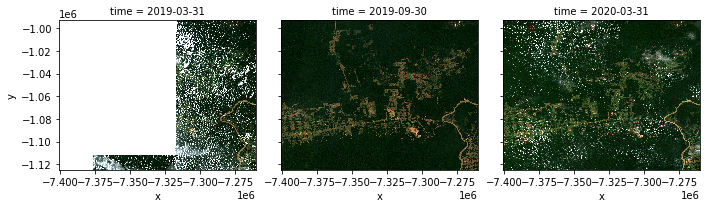

In [11]:
stack_array.sel(band=["red", "green", "blue"]).plot.imshow(
    col="time",
    col_wrap=4,
    rgb="band",
    robust=True)

In [12]:
stack_array.shape

(3, 4, 1319, 1405)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


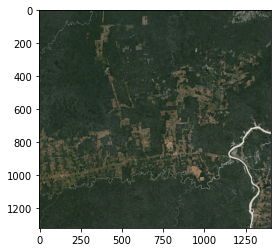

In [13]:
plt.imshow(np.moveaxis(np.array(stack_array)[1],0,-1)/3000)

In [14]:
def save_tif(filename, image, poly, channels, crs, dtype='uint8', factor=1):
    height, width = image.shape[1:]
    geotiff_transform = rasterio.transform.from_bounds(poly.bounds[0], poly.bounds[1],
                                                       poly.bounds[2], poly.bounds[3],
                                                       width/factor, height/factor)

    new_dataset = rasterio.open(filename, 'w', driver='GTiff',
                                height=height/factor, width=width/factor,
                                count=channels, dtype=dtype,
                                crs=crs,
                                transform=geotiff_transform)

    # Write bands
    for i in range(channels):
        new_dataset.write(image[i],i+1)
    new_dataset.close()
    
    return True

In [15]:
import rasterio
save_tif('./outputs/2019.tif', np.array(stack_array)[1], region_wm, channels=4, crs=3857,dtype='uint16')

True